<a href="https://colab.research.google.com/github/Harleen8118/Machine_Learning_Lab/blob/main/breast_cancerDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning Florence-2 on a Custom Object Detection Dataset

This notebook provides a streamlined approach to fine-tuning the Florence-2 model for object detection using your local JSONL file and image folder. It includes data preparation, model configuration, training, inference, evaluation, and saving the fine-tuned model.

## 1. Setup and Install Dependencies

In [ ]:
# Install necessary libraries
!pip install -q transformers flash_attn timm einops peft supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 40.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 kB 15.2 MB/s eta 0:00:00


## 2. Import Libraries and Configure Device

In [ ]:
# Imports
import os
import json
import re
import torch
import html
import base64
import itertools
import numpy as np
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import WeightedRandomSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch.nn as nn


from torch.utils.data import Dataset, DataLoader, random_split
from transformers import (
    AdamW,
    AutoModelForCausalLM,
    AutoProcessor,
    get_scheduler
)
from tqdm import tqdm
from typing import List, Dict, Any, Tuple
from peft import LoraConfig, get_peft_model
import supervision as sv
from IPython.core.display import display, HTML

# Device Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Using device: cuda


## 3. Data Preparation

### Parameters

- **JSONL_PATH**: Path to your local JSONL annotations file.
- **IMAGE_DIR**: Path to your local images directory.
- **TRAIN_SPLIT**: Fraction of data to be used for training (e.g., 0.8 for 80%).
- **BATCH_SIZE**: Number of samples per batch.
- **NUM_WORKERS**: Number of subprocesses for data loading.

In [ ]:
# prompt: unzip all_images_combined.zip into images folder

!unzip all_images_combined.zip -d images


Archive:  all_images_combined.zip
  inflating: images/benign (1).png   
  inflating: images/benign (10).png  
  inflating: images/benign (100).png  
  inflating: images/benign (101).png  
  inflating: images/benign (102).png  
  inflating: images/benign (103).png  
  inflating: images/benign (104).png  
  inflating: images/benign (105).png  
  inflating: images/benign (106).png  
  inflating: images/benign (107).png  
  inflating: images/benign (108).png  
  inflating: images/benign (109).png  
  inflating: images/benign (11).png  
  inflating: images/benign (110).png  
  inflating: images/benign (111).png  
  inflating: images/benign (112).png  
  inflating: images/benign (113).png  
  inflating: images/benign (114).png  
  inflating: images/benign (115).png  
  inflating: images/benign (116).png  
  inflating: images/benign (117).png  
  inflating: images/benign (118).png  
  inflating: images/benign (119).png  
  inflating: images/benign (12).png  
  inflating: images/benign (120).p

In [ ]:
# Parameters
JSONL_PATH = "./data.jsonl"  # Replace with your JSONL file path
IMAGE_DIR = "./images/"           # Replace with your images directory path
TRAIN_SPLIT = 0.8                              # 80% training, 20% validation
BATCH_SIZE = 4
NUM_WORKERS = 0                                 # Adjust based on your system

### Dataset Classes

We define two classes:

- **JSONLDataset**: Handles loading of JSONL entries and corresponding images.
- **DetectionDataset**: Extends `torch.utils.data.Dataset` for use with DataLoader.

In [ ]:
class JSONLDataset:
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.jsonl_file_path = jsonl_file_path
        self.image_directory_path = image_directory_path
        self.entries = self._load_entries()

    def _load_entries(self) -> List[Dict[str, Any]]:
        entries = []
        with open(self.jsonl_file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                entries.append(data)
        return entries

    def __len__(self) -> int:
        return len(self.entries)

    def __getitem__(self, idx: int) -> Tuple[Image.Image, Dict[str, Any]]:
        if idx < 0 or idx >= len(self.entries):
            raise IndexError("Index out of range")

        entry = self.entries[idx]
        image_path = os.path.join(self.image_directory_path, entry['image'])
        try:
            image = Image.open(image_path).convert("RGB")
            return image, entry
        except FileNotFoundError:
            raise FileNotFoundError(f"Image file {image_path} not found.")

class DetectionDataset(Dataset):
    def __init__(self, jsonl_file_path: str, image_directory_path: str, augment=False):
        self.dataset = JSONLDataset(jsonl_file_path, image_directory_path)
        self.augment = augment
        self.augmentation = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Rotate(limit=10, p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.RandomResizedCrop(height=500, width=500, scale=(0.9, 1.0), p=0.5),
            A.GaussNoise(p=0.5),
            A.ElasticTransform(p=0.5),
            ToTensorV2()
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, data = self.dataset[idx]
        prefix = data['prefix']
        suffix = data['suffix']

        # Apply augmentation if enabled
        if self.augment:
            image = np.array(image)
            augmented = self.augmentation(image=image)
            image = augmented['image']
        return prefix, suffix, image

### Load and Split Dataset

In [ ]:
# Load Full Dataset with and without augmentation
train_dataset = DetectionDataset(jsonl_file_path=JSONL_PATH, image_directory_path=IMAGE_DIR, augment=True)
val_dataset = DetectionDataset(jsonl_file_path=JSONL_PATH, image_directory_path=IMAGE_DIR, augment=False)
#full_dataset = DetectionDataset(jsonl_file_path=JSONL_PATH, image_directory_path=IMAGE_DIR, augment=True)

# Split into Training and Validation Sets
#train_size = int(TRAIN_SPLIT * len(full_dataset))
#val_size = len(full_dataset) - train_size
#train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
# Split into Training and Validation Sets
train_size = int(TRAIN_SPLIT * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])


#print(f"Total samples: {len(full_dataset)}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Training samples: 624
Validation samples: 156


### Processor and Tokenizer Setup

We use `AutoProcessor` from HuggingFace to handle both image and text processing.

In [ ]:
CHECKPOINT = "microsoft/Florence-2-base-ft"
REVISION = 'refs/pr/6'

model = AutoModelForCausalLM.from_pretrained(CHECKPOINT, trust_remote_code=True, revision=REVISION).to(DEVICE)
processor = AutoProcessor.from_pretrained(CHECKPOINT, trust_remote_code=True, revision=REVISION)

config.json:   0%|          | 0.00/2.43k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/464M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base-ft:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


### Collate Function

The `collate_fn` function prepares batches by processing text and images.

In [ ]:
def collate_fn(batch):
    questions, answers, images = zip(*batch)
    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(DEVICE)
    return inputs, answers

In [ ]:
# Define class counts
class_counts = [133, 437, 210]  # [normal, benign, malignant]
total_samples = sum(class_counts)
class_weights = [total_samples / count for count in class_counts]

# Create sample weights
def get_sample_weights(dataset):
    # Assuming dataset provides label as index 1 in the return tuple
    sample_weights = []
    for _, suffix, _ in dataset:
        # Extract the label from suffix (update this depending on how labels are stored in your dataset)
        if "normal" in suffix:
            sample_weights.append(class_weights[0])
        elif "benign" in suffix:
            sample_weights.append(class_weights[1])
        elif "malignant" in suffix:
            sample_weights.append(class_weights[2])
    return sample_weights

# Assign weights to samples for the train dataset
train_sample_weights = get_sample_weights(train_dataset)
train_sampler = WeightedRandomSampler(weights=train_sample_weights, num_samples=len(train_sample_weights), replacement=True)


### DataLoaders

In [ ]:
# DataLoaders with weighted sampler for balanced training
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, collate_fn=collate_fn, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=0)

## 4. Model Configuration

### Load Pre-trained Model

We load the pre-trained Florence-2 model and prepare it for fine-tuning using LoRA (Low-Rank Adaptation).

In [ ]:
# Load Pre-trained Model
model = AutoModelForCausalLM.from_pretrained(CHECKPOINT, trust_remote_code=True, revision=REVISION).to(DEVICE)

### Configure LoRA

In [ ]:
# Configure LoRA
config = LoraConfig(
    r=32,
    lora_alpha=32,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "Conv2d"],
    task_type="OBJECT_DETECTION",
    lora_dropout=0.2,
    bias="none",
    inference_mode=False,
    use_rslora=True,
    init_lora_weights="gaussian",
    revision=REVISION
)

peft_model = get_peft_model(model, config)
peft_model.print_trainable_parameters()



trainable params: 2,654,208 || all params: 273,458,176 || trainable%: 0.9706


In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()


462

## Render Functions

Defines functions to render images with detections and run inference on sample images.

In [ ]:
import io
def render_inline(image: Image.Image, resize=(128, 128)):
    """Convert image into inline HTML."""
    image = image.copy()
    image.thumbnail(resize)
    with io.BytesIO() as buffer:
        image.save(buffer, format='JPEG')
        image_b64 = base64.b64encode(buffer.getvalue()).decode("utf-8")
        return f"data:image/jpeg;base64,{image_b64}"

def render_example(image: Image.Image, response):
    try:
        detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)
        image = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX).annotate(image.copy(), detections)
        image = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX).annotate(image, detections)
    except Exception as e:
        print(f"Failed to render model response: {e}")
    return f"""
<div style="display: inline-flex; align-items: center; justify-content: center; margin: 10px;">
    <img style="width:256px; height:256px;" src="{render_inline(image, resize=(512, 512))}" />
    <p style="width:512px; margin:10px; font-size:small;">{html.escape(json.dumps(response))}</p>
</div>
"""

def render_inference_results(model, dataset: DetectionDataset, count: int):
    html_out = ""
    count = min(count, len(dataset))
    for i in range(count):
        prefix, suffix, image = dataset.dataset[i]
        # prefix = data[0]
        # suffix = data[1]
        inputs = processor(text=prefix, images=image, return_tensors="pt").to(DEVICE)
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=1024,
            num_beams=3
        )
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
        answer = processor.post_process_generation(generated_text, task='<OD>', image_size=image.size)
        html_out += render_example(image, answer)

    display(HTML(html_out))

## 5. Training Loop

Defines the training and validation process, including loss computation and optimization.

In [ ]:
#def train_model(train_loader, val_loader, model, processor, epochs=10, lr=1e-6):
    optimizer = AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=1000,
        num_training_steps=num_training_steps,
    )

    render_inference_results(peft_model, val_loader.dataset, 6)

    avg_train_losses = []
    avg_val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, answers in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):

            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"]
            labels = processor.tokenizer(
                text=answers,
                return_tensors="pt",
                padding=True,
                return_token_type_ids=False
            ).input_ids.to(DEVICE)

            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            loss.backward(), optimizer.step(), lr_scheduler.step(), optimizer.zero_grad()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Average Training Loss: {avg_train_loss}")

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, answers in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):

                input_ids = inputs["input_ids"]
                pixel_values = inputs["pixel_values"]
                labels = processor.tokenizer(
                    text=answers,
                    return_tensors="pt",
                    padding=True,
                    return_token_type_ids=False
                ).input_ids.to(DEVICE)

                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

                val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)
            print(f"Average Validation Loss: {avg_val_loss}")

            render_inference_results(peft_model, val_loader.dataset, 6)

    #    output_dir = f"./model_checkpoints/epoch_{epoch+1}"
   #     os.makedirs(output_dir, exist_ok=True)
  #      model.save_pretrained(output_dir)
 #       processor.save_pretrained(output_dir)


In [ ]:

def train_model(train_loader, val_loader, model, processor, epochs=10, lr=1e-6):
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=int(0.1 * num_training_steps),
        num_training_steps=num_training_steps,
    )

    # Enhanced Logging: Track losses and metrics
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    training_accuracy = []
    validation_accuracy = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        y_true_train, y_pred_train = [], []

        # Training Loop
        for inputs, answers in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"]
            labels = processor.tokenizer(
                text=answers,
                return_tensors="pt",
                padding=True,
                return_token_type_ids=False
            ).input_ids.to(DEVICE)

            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            running_loss += loss.item()

            # Track predictions for accuracy
            y_true_train.extend(labels.cpu().numpy().flatten())
            y_pred_train.extend(outputs.logits.argmax(dim=-1).cpu().numpy().flatten())

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_acc = accuracy_score(y_true_train, y_pred_train)
        training_accuracy.append(train_acc)

        print(f"Epoch [{epoch + 1}/{epochs}] - Training Loss: {avg_train_loss:.4f} - Training Accuracy: {train_acc:.4f}")

        # Validation Loop
        model.eval()
        val_loss = 0.0
        y_true_val, y_pred_val = [], []

        with torch.no_grad():
            for inputs, answers in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):
                input_ids = inputs["input_ids"]
                pixel_values = inputs["pixel_values"]
                labels = processor.tokenizer(
                    text=answers,
                    return_tensors="pt",
                    padding=True,
                    return_token_type_ids=False
                ).input_ids.to(DEVICE)

                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

                val_loss += loss.item()
                y_true_val.extend(labels.cpu().numpy().flatten())
                y_pred_val.extend(outputs.logits.argmax(dim=-1).cpu().numpy().flatten())

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_acc = accuracy_score(y_true_val, y_pred_val)
        validation_accuracy.append(val_acc)

        print(f"Epoch [{epoch + 1}/{epochs}] - Validation Loss: {avg_val_loss:.4f} - Validation Accuracy: {val_acc:.4f}")

        # Log metrics
        train_precision = precision_score(y_true_train, y_pred_train, average='weighted', zero_division=1)
        train_recall = recall_score(y_true_train, y_pred_train, average='weighted', zero_division=1)
        train_f1 = f1_score(y_true_train, y_pred_train, average='weighted', zero_division=1)
        val_precision = precision_score(y_true_val, y_pred_val, average='weighted', zero_division=1)
        val_recall = recall_score(y_true_val, y_pred_val, average='weighted', zero_division=1)
        val_f1 = f1_score(y_true_val, y_pred_val, average='weighted', zero_division=1)

        print(f"Training Precision: {train_precision:.4f}, Training Recall: {train_recall:.4f}, Training F1: {train_f1:.4f}")
        print(f"Validation Precision: {val_precision:.4f}, Validation Recall: {val_recall:.4f}, Validation F1: {val_f1:.4f}")

        # Check for the best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            print("Validation loss improved. Saving the model...")
            model.save_pretrained('./best_model_checkpoint/')
            processor.save_pretrained('./best_model_checkpoint/')

    print("Training Complete.")


### Run Training

Set the number of epochs and learning rate, then start the training process.

In [ ]:
# Set the start method for multiprocessing
torch.multiprocessing.set_start_method('spawn', force=True)


In [ ]:
# @title Run train loop

%%time

EPOCHS = 20
LR = 3e-5
BATCH_SIZE = 16

train_model(train_loader, val_loader, peft_model, processor, epochs=EPOCHS, lr=LR)


Training Epoch 1/20: 100%|██████████| 156/156 [03:14<00:00,  1.25s/it]


Epoch [1/20] - Training Loss: 5.9119 - Training Accuracy: 0.3396


Validation Epoch 1/20: 100%|██████████| 39/39 [00:43<00:00,  1.11s/it]


Epoch [1/20] - Validation Loss: 3.5449 - Validation Accuracy: 0.4095
Training Precision: 0.6418, Training Recall: 0.3396, Training F1: 0.2952
Validation Precision: 0.7935, Validation Recall: 0.4095, Validation F1: 0.3503
Validation loss improved. Saving the model...


config.json:   0%|          | 0.00/2.43k [00:00<?, ?B/s]

Training Epoch 2/20: 100%|██████████| 156/156 [03:15<00:00,  1.26s/it]


Epoch [2/20] - Training Loss: 3.3183 - Training Accuracy: 0.4285


Validation Epoch 2/20: 100%|██████████| 39/39 [00:42<00:00,  1.09s/it]


Epoch [2/20] - Validation Loss: 2.8857 - Validation Accuracy: 0.4888
Training Precision: 0.6543, Training Recall: 0.4285, Training F1: 0.3786
Validation Precision: 0.8455, Validation Recall: 0.4888, Validation F1: 0.4406
Validation loss improved. Saving the model...


Training Epoch 3/20: 100%|██████████| 156/156 [03:15<00:00,  1.25s/it]


Epoch [3/20] - Training Loss: 2.8263 - Training Accuracy: 0.4909


Validation Epoch 3/20: 100%|██████████| 39/39 [00:43<00:00,  1.11s/it]


Epoch [3/20] - Validation Loss: 2.8198 - Validation Accuracy: 0.4872
Training Precision: 0.6712, Training Recall: 0.4909, Training F1: 0.4430
Validation Precision: 0.8420, Validation Recall: 0.4872, Validation F1: 0.4452
Validation loss improved. Saving the model...


Training Epoch 4/20: 100%|██████████| 156/156 [03:15<00:00,  1.25s/it]


Epoch [4/20] - Training Loss: 2.7604 - Training Accuracy: 0.5008


Validation Epoch 4/20: 100%|██████████| 39/39 [00:42<00:00,  1.09s/it]


Epoch [4/20] - Validation Loss: 2.6887 - Validation Accuracy: 0.5112
Training Precision: 0.7040, Training Recall: 0.5008, Training F1: 0.4565
Validation Precision: 0.8563, Validation Recall: 0.5112, Validation F1: 0.4692
Validation loss improved. Saving the model...


Training Epoch 5/20: 100%|██████████| 156/156 [03:10<00:00,  1.22s/it]


Epoch [5/20] - Training Loss: 2.6628 - Training Accuracy: 0.5066


Validation Epoch 5/20: 100%|██████████| 39/39 [00:42<00:00,  1.09s/it]


Epoch [5/20] - Validation Loss: 2.6437 - Validation Accuracy: 0.5088
Training Precision: 0.6770, Training Recall: 0.5066, Training F1: 0.4705
Validation Precision: 0.8526, Validation Recall: 0.5088, Validation F1: 0.4804
Validation loss improved. Saving the model...


Training Epoch 6/20: 100%|██████████| 156/156 [03:15<00:00,  1.25s/it]


Epoch [6/20] - Training Loss: 2.6145 - Training Accuracy: 0.5106


Validation Epoch 6/20: 100%|██████████| 39/39 [00:41<00:00,  1.07s/it]


Epoch [6/20] - Validation Loss: 2.6490 - Validation Accuracy: 0.5136
Training Precision: 0.6834, Training Recall: 0.5106, Training F1: 0.4819
Validation Precision: 0.8459, Validation Recall: 0.5136, Validation F1: 0.4977


Training Epoch 7/20: 100%|██████████| 156/156 [03:15<00:00,  1.26s/it]


Epoch [7/20] - Training Loss: 2.5761 - Training Accuracy: 0.5147


Validation Epoch 7/20: 100%|██████████| 39/39 [00:42<00:00,  1.09s/it]


Epoch [7/20] - Validation Loss: 2.6292 - Validation Accuracy: 0.5128
Training Precision: 0.6984, Training Recall: 0.5147, Training F1: 0.4930
Validation Precision: 0.8496, Validation Recall: 0.5128, Validation F1: 0.4961
Validation loss improved. Saving the model...


Training Epoch 8/20: 100%|██████████| 156/156 [03:14<00:00,  1.25s/it]


Epoch [8/20] - Training Loss: 2.5475 - Training Accuracy: 0.5164


Validation Epoch 8/20: 100%|██████████| 39/39 [00:42<00:00,  1.08s/it]


Epoch [8/20] - Validation Loss: 2.6218 - Validation Accuracy: 0.5184
Training Precision: 0.6831, Training Recall: 0.5164, Training F1: 0.4924
Validation Precision: 0.8617, Validation Recall: 0.5184, Validation F1: 0.5008
Validation loss improved. Saving the model...


Training Epoch 9/20: 100%|██████████| 156/156 [03:12<00:00,  1.23s/it]


Epoch [9/20] - Training Loss: 2.4950 - Training Accuracy: 0.5213


Validation Epoch 9/20: 100%|██████████| 39/39 [00:43<00:00,  1.11s/it]


Epoch [9/20] - Validation Loss: 2.6167 - Validation Accuracy: 0.5088
Training Precision: 0.6943, Training Recall: 0.5213, Training F1: 0.5012
Validation Precision: 0.8522, Validation Recall: 0.5088, Validation F1: 0.4926
Validation loss improved. Saving the model...


Training Epoch 10/20: 100%|██████████| 156/156 [03:16<00:00,  1.26s/it]


Epoch [10/20] - Training Loss: 2.4871 - Training Accuracy: 0.5259


Validation Epoch 10/20: 100%|██████████| 39/39 [00:43<00:00,  1.12s/it]


Epoch [10/20] - Validation Loss: 2.5843 - Validation Accuracy: 0.5160
Training Precision: 0.7022, Training Recall: 0.5259, Training F1: 0.5076
Validation Precision: 0.8620, Validation Recall: 0.5160, Validation F1: 0.5011
Validation loss improved. Saving the model...


Training Epoch 11/20: 100%|██████████| 156/156 [03:13<00:00,  1.24s/it]


Epoch [11/20] - Training Loss: 2.4160 - Training Accuracy: 0.5299


Validation Epoch 11/20: 100%|██████████| 39/39 [00:42<00:00,  1.10s/it]


Epoch [11/20] - Validation Loss: 2.5871 - Validation Accuracy: 0.5080
Training Precision: 0.7154, Training Recall: 0.5299, Training F1: 0.5138
Validation Precision: 0.8676, Validation Recall: 0.5080, Validation F1: 0.4906


Training Epoch 12/20: 100%|██████████| 156/156 [03:14<00:00,  1.25s/it]


Epoch [12/20] - Training Loss: 2.4145 - Training Accuracy: 0.5309


Validation Epoch 12/20: 100%|██████████| 39/39 [00:42<00:00,  1.09s/it]


Epoch [12/20] - Validation Loss: 2.5528 - Validation Accuracy: 0.5232
Training Precision: 0.7342, Training Recall: 0.5309, Training F1: 0.5168
Validation Precision: 0.8641, Validation Recall: 0.5232, Validation F1: 0.5070
Validation loss improved. Saving the model...


Training Epoch 13/20: 100%|██████████| 156/156 [03:14<00:00,  1.25s/it]


Epoch [13/20] - Training Loss: 2.4114 - Training Accuracy: 0.5317


Validation Epoch 13/20: 100%|██████████| 39/39 [00:43<00:00,  1.12s/it]


Epoch [13/20] - Validation Loss: 2.5946 - Validation Accuracy: 0.5136
Training Precision: 0.7084, Training Recall: 0.5317, Training F1: 0.5116
Validation Precision: 0.8450, Validation Recall: 0.5136, Validation F1: 0.4955


Training Epoch 14/20: 100%|██████████| 156/156 [03:13<00:00,  1.24s/it]


Epoch [14/20] - Training Loss: 2.4234 - Training Accuracy: 0.5254


Validation Epoch 14/20: 100%|██████████| 39/39 [00:40<00:00,  1.04s/it]


Epoch [14/20] - Validation Loss: 2.5593 - Validation Accuracy: 0.5184
Training Precision: 0.7063, Training Recall: 0.5254, Training F1: 0.5039
Validation Precision: 0.8523, Validation Recall: 0.5184, Validation F1: 0.5031


Training Epoch 15/20: 100%|██████████| 156/156 [03:14<00:00,  1.25s/it]


Epoch [15/20] - Training Loss: 2.4105 - Training Accuracy: 0.5327


Validation Epoch 15/20: 100%|██████████| 39/39 [00:42<00:00,  1.10s/it]


Epoch [15/20] - Validation Loss: 2.5193 - Validation Accuracy: 0.5272
Training Precision: 0.7099, Training Recall: 0.5327, Training F1: 0.5133
Validation Precision: 0.8575, Validation Recall: 0.5272, Validation F1: 0.5181
Validation loss improved. Saving the model...


Training Epoch 16/20: 100%|██████████| 156/156 [03:14<00:00,  1.24s/it]


Epoch [16/20] - Training Loss: 2.4069 - Training Accuracy: 0.5288


Validation Epoch 16/20: 100%|██████████| 39/39 [00:42<00:00,  1.09s/it]


Epoch [16/20] - Validation Loss: 2.5335 - Validation Accuracy: 0.5192
Training Precision: 0.7194, Training Recall: 0.5288, Training F1: 0.5173
Validation Precision: 0.8547, Validation Recall: 0.5192, Validation F1: 0.5076


Training Epoch 17/20: 100%|██████████| 156/156 [03:16<00:00,  1.26s/it]


Epoch [17/20] - Training Loss: 2.3563 - Training Accuracy: 0.5367


Validation Epoch 17/20: 100%|██████████| 39/39 [00:42<00:00,  1.09s/it]


Epoch [17/20] - Validation Loss: 2.5547 - Validation Accuracy: 0.5184
Training Precision: 0.7126, Training Recall: 0.5367, Training F1: 0.5205
Validation Precision: 0.8541, Validation Recall: 0.5184, Validation F1: 0.5082


Training Epoch 18/20: 100%|██████████| 156/156 [03:16<00:00,  1.26s/it]


Epoch [18/20] - Training Loss: 2.3269 - Training Accuracy: 0.5395


Validation Epoch 18/20: 100%|██████████| 39/39 [00:41<00:00,  1.07s/it]


Epoch [18/20] - Validation Loss: 2.5332 - Validation Accuracy: 0.5192
Training Precision: 0.7296, Training Recall: 0.5395, Training F1: 0.5239
Validation Precision: 0.8510, Validation Recall: 0.5192, Validation F1: 0.5056


Training Epoch 19/20: 100%|██████████| 156/156 [03:14<00:00,  1.25s/it]


Epoch [19/20] - Training Loss: 2.3574 - Training Accuracy: 0.5335


Validation Epoch 19/20: 100%|██████████| 39/39 [00:41<00:00,  1.07s/it]


Epoch [19/20] - Validation Loss: 2.5341 - Validation Accuracy: 0.5232
Training Precision: 0.7217, Training Recall: 0.5335, Training F1: 0.5191
Validation Precision: 0.8516, Validation Recall: 0.5232, Validation F1: 0.5068


Training Epoch 20/20: 100%|██████████| 156/156 [03:15<00:00,  1.25s/it]


Epoch [20/20] - Training Loss: 2.3490 - Training Accuracy: 0.5379


Validation Epoch 20/20: 100%|██████████| 39/39 [00:42<00:00,  1.09s/it]

Epoch [20/20] - Validation Loss: 2.5299 - Validation Accuracy: 0.5232
Training Precision: 0.7180, Training Recall: 0.5379, Training F1: 0.5241
Validation Precision: 0.8578, Validation Recall: 0.5232, Validation F1: 0.5137
Training Complete.
CPU times: user 1h 17min 33s, sys: 1min 52s, total: 1h 19min 25s
Wall time: 1h 19min 12s


In [ ]:
val_loader.dataset[0]

('<OD>',
 'benign<loc_320><loc_89><loc_438><loc_168>',
 tensor([[[ 13,  10,   6,  ...,  13,  13,  18],
          [ 13,  12,  18,  ...,  10,  19,  22],
          [ 12,  13,  17,  ...,  15,  14,  13],
          ...,
          [ 85,  81,  81,  ..., 103, 103,  99],
          [ 88,  77,  78,  ..., 114, 108, 108],
          [ 80,  79,  80,  ..., 119, 116, 114]],
 
         [[ 13,   7,  14,  ...,  15,  16,  15],
          [ 19,  17,  13,  ...,  15,  16,  24],
          [ 14,  13,  11,  ...,  14,  11,  18],
          ...,
          [ 88,  84,  77,  ..., 100, 106,  96],
          [ 90,  80,  81,  ..., 115, 111, 109],
          [ 84,  77,  78,  ..., 120, 122, 113]],
 
         [[ 15,  14,   2,  ...,  10,  17,  19],
          [ 12,   9,  15,  ...,  15,  18,  18],
          [ 17,  14,  15,  ...,  12,  16,  18],
          ...,
          [ 82,  83,  82,  ..., 108, 100,  98],
          [ 89,  82,  83,  ..., 118, 109, 109],
          [ 86,  81,  75,  ..., 119, 113, 111]]], dtype=torch.uint8))

## 7. Evaluation

### Extract Classes from Training Data

In [ ]:
PATTERN = r'([a-zA-Z0-9 ]+)<loc_\d+>'
def extract_classes(dataset: DetectionDataset):
    class_set = set()
    for i in range(len(dataset.dataset)):
        data = dataset.dataset[i]
        prefix, suffix, image = dataset.dataset[i]
        classes = re.findall(PATTERN, suffix)
        class_set.update(classes)
    return sorted(class_set)

CLASSES = extract_classes(train_dataset)
print(f"Detected Classes: {CLASSES}")

Detected Classes: ['benign', 'malignant', 'normal']


### Collect Predictions and Targets

In [ ]:
predictions = []
targets = []

for i in tqdm(range(len(val_dataset.dataset)), desc="Collecting Predictions"):
    prefix, suffix, image = val_dataset.dataset[i]
    # prefix = data['prefix']
    # suffix = data['suffix']

    inputs = processor(text=prefix, images=image, return_tensors="pt").to(DEVICE)
    generated_ids = peft_model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

    # Prediction
    # Get image width and height from image.shape
    image_size = (image.shape[2], image.shape[1])
    prediction = processor.post_process_generation(generated_text, task='<OD>', image_size=image_size)
    prediction = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, prediction, resolution_wh=image_size)
    prediction = prediction[np.isin(prediction['class_name'], CLASSES)]
    prediction.class_id = np.array([CLASSES.index(cls) for cls in prediction['class_name']])
    prediction.confidence = np.ones(len(prediction))  # Assuming confidence = 1

    # Target
    target = processor.post_process_generation(suffix, task='<OD>', image_size=image_size)
    target = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, target, resolution_wh=image_size)
    target.class_id = np.array([CLASSES.index(cls) for cls in target['class_name']])

    predictions.append(prediction)
    targets.append(target)

### Calculate Mean Average Precision (mAP)

In [ ]:
# Calculate Mean Average Precision (mAP)
mean_average_precision = sv.MeanAveragePrecision.from_detections(
    predictions=predictions,
    targets=targets,
)

print(f"mAP50-95: {mean_average_precision.map50_95:.2f}")
print(f"mAP50: {mean_average_precision.map50:.2f}")
print(f"mAP75: {mean_average_precision.map75:.2f}")

mAP50-95: 0.14
mAP50: 0.27
mAP75: 0.10


### Plot Confusion Matrix

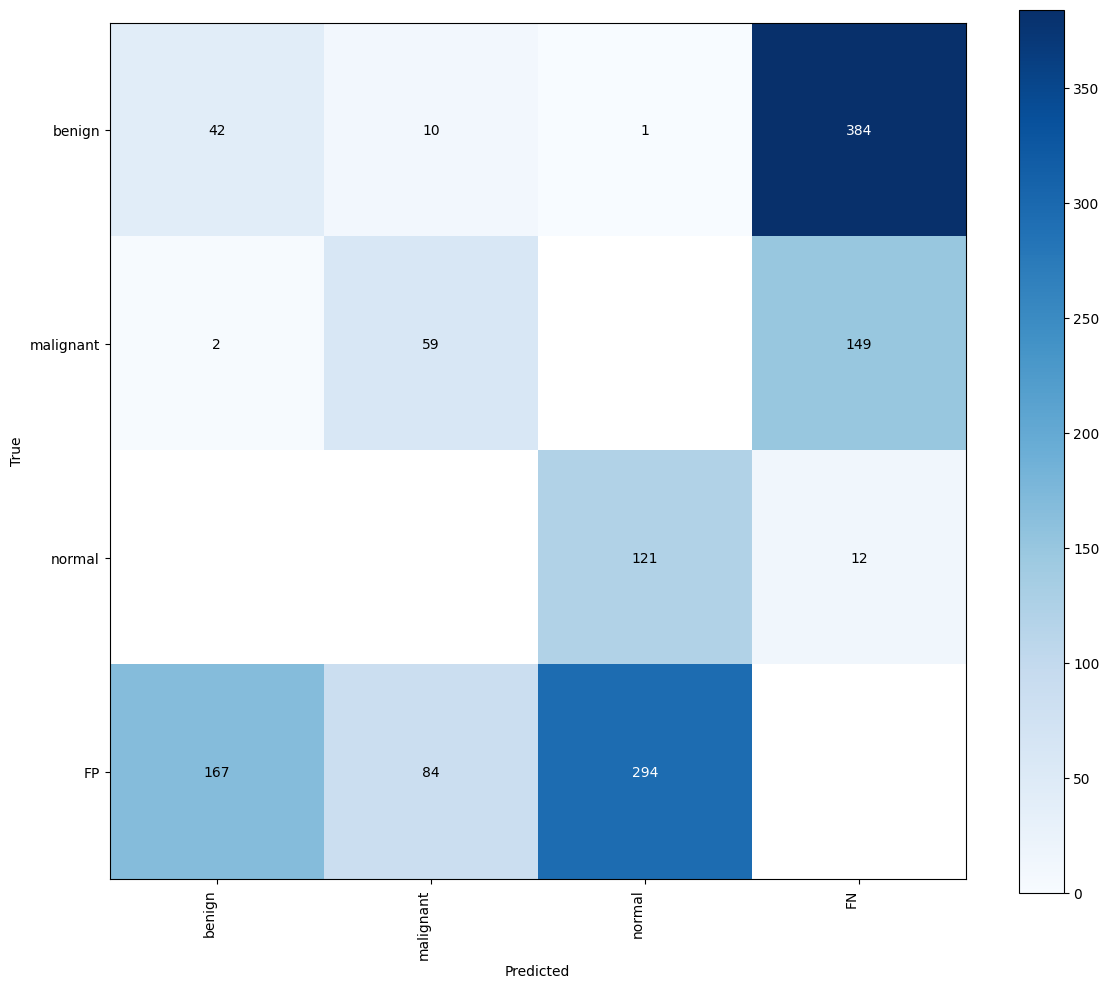

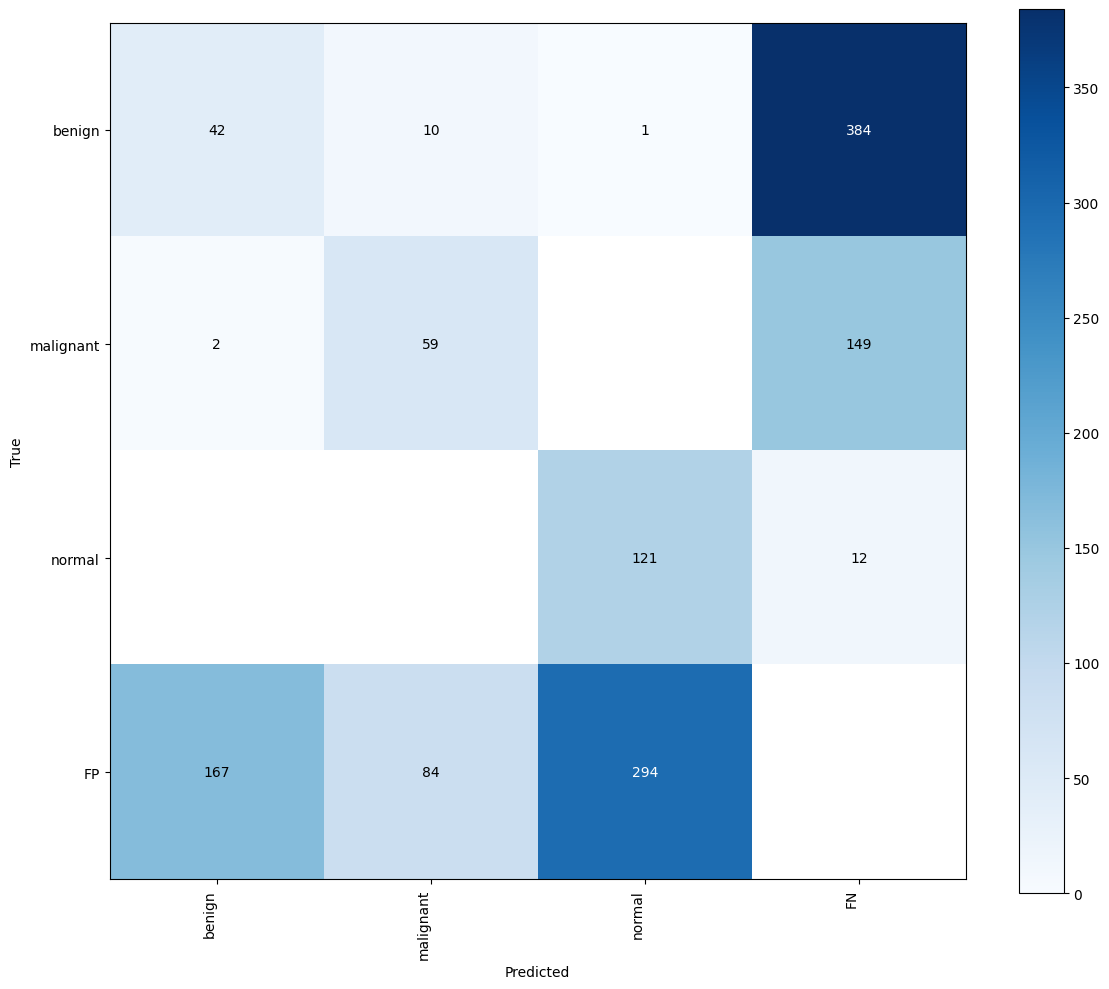

In [ ]:
# Plot Confusion Matrix
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=CLASSES
)

confusion_matrix.plot()

## 8. Save Fine-Tuned Model

Save the fine-tuned model and processor to a specified directory.

In [ ]:
!pip install huggingface_hub

In [ ]:
from huggingface_hub import notebook_login

notebook_login()


In [ ]:
# Save Fine-Tuned Model
output_model_dir = "./florence2-lora"
os.makedirs(output_model_dir, exist_ok=True)

peft_model.save_pretrained(output_model_dir)
processor.save_pretrained(output_model_dir)

print(f"Fine-tuned model saved to {output_model_dir}")
print("Directory contents:")
!ls -la {output_model_dir}/

Fine-tuned model saved to ./florence2-lora
Directory contents:
total 11432
drwxr-xr-x 2 root root    4096 Sep 30 12:38 .
drwxr-xr-x 1 root root    4096 Sep 30 12:38 ..
-rw-r--r-- 1 root root     746 Sep 30 12:38 adapter_config.json
-rw-r--r-- 1 root root 7747264 Sep 30 12:38 adapter_model.safetensors
-rw-r--r-- 1 root root   22410 Sep 30 12:38 added_tokens.json
-rw-r--r-- 1 root root  456318 Sep 30 12:38 merges.txt
-rw-r--r-- 1 root root     633 Sep 30 12:38 preprocessor_config.json
-rw-r--r-- 1 root root    5102 Sep 30 12:38 README.md
-rw-r--r-- 1 root root  146627 Sep 30 12:38 special_tokens_map.json
-rw-r--r-- 1 root root  197658 Sep 30 12:38 tokenizer_config.json
-rw-r--r-- 1 root root 2297961 Sep 30 12:38 tokenizer.json
-rw-r--r-- 1 root root  798293 Sep 30 12:38 vocab.json


In [ ]:
peft_model.push_to_hub('harleenbagga/florence2-breast-cander-detection')
processor.push_to_hub('harleenbagga/florence2-breast-cander-detection')

adapter_model.safetensors:   0%|          | 0.00/7.75M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/harleenbagga/florence2-breast-cander-detection/commit/9ed87e9e796efd1eacad46ed072c1b1ab6b03b32', commit_message='Upload model', commit_description='', oid='9ed87e9e796efd1eacad46ed072c1b1ab6b03b32', pr_url=None, pr_revision=None, pr_num=None)

## 9. Inference with Fine-Tuned Model

Define a function to run inference on new images using the fine-tuned model.

In [ ]:
# Function to Run Inference on a Single Image
def run_inference(model, processor, image_path: str, task: str = "<OD>"):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(text=task, images=image, return_tensors="pt").to(DEVICE)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    response = processor.post_process_generation(generated_text, task=task, image_size=image.size)
    detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

    bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
    label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

    image = bounding_box_annotator.annotate(image, detections)
    image = label_annotator.annotate(image, detections)
    image.thumbnail((600, 600))
    display(image)

### Run Inference on an Example Image

In [ ]:
# Example Inference
EXAMPLE_IMAGE_PATH = "./benign (109).png"  # Replace with your image path
run_inference(peft_model, processor, EXAMPLE_IMAGE_PATH, task="<Given an MRI image detect and mark cancer part.benign meligant normal If it's normal then mark the whole image else mark the particular meligant or begin>")

NameError: name 'peft_model' is not defined

In [ ]:
peft_model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Florence2ForConditionalGeneration(
      (vision_tower): DaViT(
        (convs): ModuleList(
          (0): ConvEmbed(
            (proj): Conv2d(3, 128, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
            (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          )
          (1): ConvEmbed(
            (proj): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          )
          (2): ConvEmbed(
            (proj): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          )
          (3): ConvEmbed(
            (proj): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          )
        )
        (blocks): ModuleList(
      

## Conclusion

We presented an enhanced method for breast cancer detection in ultrasound images by fine-tuning the Florence2 base model using LoRA. Achieving an mAP50 of 0.53
demonstrates significant potential for clinical application. By
reducing computational requirements and improving detection
accuracy, our method offers a practical solution for resourceconstrained environments.